In [1]:
#importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ConstantKernel, ExpSineSquared, RBF, RationalQuadratic
from itertools import product
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate as CV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import random
import time
import math

In [2]:
# Load the spreadsheet
file_path = 'Bare BO dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

# Renaming columns for clarity
data.columns = ['Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo', 'Objective']

# Preprocessing
X = data[['Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo']].values
y = data['Objective'].values
X = (X)/100

In [4]:
#fitting
kernel = 1.0 * Matern(nu=1.5) 
gp = GaussianProcessRegressor(kernel=kernel, alpha = 0.3, n_restarts_optimizer=1000, normalize_y = True)
gp.fit(X, y)
gp.kernel_

0.849**2 * Matern(length_scale=0.146, nu=1.5)

In [ ]:
X_list = []
y_list = []
for i in range(2,150):
    X_list.append(X[0:i+1])
    y_list.append(y[0:i+1])
    gp.fit(X_list[i-2], y_list[i-2])
    print(gp.kernel_)

In [5]:
def generate_constrained_points(variable_index, n_points):
    x_points = np.linspace(0, 90, n_points)
    points = np.zeros((n_points, 6))

    for i in range(n_points):
        x = x_points[i]*0.01
        points[i, variable_index] = x

        candidates = []
        random_numbers = [random.randint(1, 100) for _ in range(5)]
        total = sum(random_numbers)
        results = [round((0.9-x)*number / total, 2) for number in random_numbers] #randomly generate 6 numbers with boundary
        candidates.append(results)
        # # allocate array
        selected_candidate = candidates[0]
        
        candidate_index = 0
        for j in range(6):
            if j != variable_index:
                points[i, j] = selected_candidate[candidate_index]
                candidate_index += 1
                
    return points

In [6]:
def average_predictions(gp, variable_index, n_points, n_iterations=10000):
    total_y_pred = 0
    total_sigma = 0
    pointsarray = []
    for _ in range(n_iterations):
        points = generate_constrained_points(variable_index, n_points)
        pointsarray.append(points)
        y_pred, sigma = gp.predict(points, return_std=True)

        total_y_pred += y_pred
        total_sigma += sigma

    # calculating the mean
    average_y_pred = total_y_pred / n_iterations
    average_sigma = total_sigma / n_iterations
    
    for i in range(n_iterations-1):
    # add pointsarray[i] to the current array
        result_array = np.concatenate((pointsarray[i], pointsarray[i+1]), axis=0)

    return average_y_pred, average_sigma, result_array

In [7]:
def find_uncertainty_by_line(gp, n_points):
    variable_index=[0,1,2,3,4,5]
    y_pred_list=[]
    sigma_list=[]
    array_list=[]
    for i in range(len(variable_index)):
        y_pred, sigma, array = average_predictions(gp, variable_index[i], n_points)
        y_pred_list.append(y_pred)
        sigma_list.append(sigma)
        array_list.append(array)
    return y_pred_list, sigma_list, array_list

In [8]:
n_points = 91  # number of x grid points

start_time = time.time()

y_pred, sigma, array = find_uncertainty_by_line(gp, n_points)

end_time = time.time()
total = end_time - start_time
print("prediction time :", total) 

prediction time : 102.06796193122864


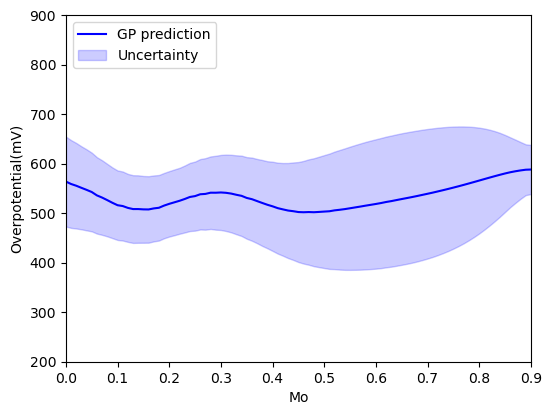

In [81]:
# Plotting
variable = [0,1,2,3,4,5]
variable_index = 5
plt.figure(figsize=(6, 4.5))
plt.plot(array[variable_index][:n_points, variable[variable_index]], y_pred[variable_index],'b-',label = 'GP prediction')
plt.fill_between(array[variable_index][:n_points, variable[variable_index]], y_pred[variable_index] - sigma[variable_index], y_pred[variable_index] + sigma[variable_index], alpha=0.2, color='blue', label = 'Uncertainty')
plt.xlabel(f'{data.columns[variable[variable_index]]}')
plt.ylabel('Overpotential(mV)')
# plt.title(f'GP Prediction and Uncertainty for {data.columns[variable_index]}')
plt.xlim(0,0.9)
plt.ylim(200,900)
plt.legend(loc='upper left')
plt.show()

In [21]:
def acquisition_func(gp, n_points):
    x_points = np.linspace(0, 90, n_points)
    points = np.zeros((n_points, 6))

    candidates = []
    y_pred_list = []
    sigma_list = []
    entropy = []
    for i in range(1000000):
        random_numbers = [random.randint(1, 100) for _ in range(6)]
        total = sum(random_numbers)
        results = [round(0.9*number / total, 2) for number in random_numbers]
        candidates.append(results)
    
    y_pred, sigma = gp.predict(candidates, return_std=True)
    return y_pred, sigma, entropy

In [22]:
y_pred, sigma, entropy, candidates = acquisition_func(gp, 91)
acq_array = y_pred.max() - y_pred + sigma*(-1)*(x*np.log(x)+(0.901-x)*np.log((0.901-x)/5)+0.1*np.log(0.05)) 
candidates_list = []
for i in range(99):
    max_acq_index = np.argmax(acq_array)
    candidates_list.append(candidates[max_acq_index])
    acq_array = np.delete(acq_array, max_acq_index, axis=0)
print(candidates_list)

[[0.01, 0.12, 0.33, 0.32, 0.01, 0.11], [0.01, 0.22, 0.03, 0.35, 0.13, 0.15], [0.18, 0.04, 0.33, 0.29, 0.04, 0.01], [0.01, 0.15, 0.29, 0.32, 0.02, 0.11], [0.14, 0.04, 0.24, 0.08, 0.17, 0.24], [0.01, 0.12, 0.32, 0.32, 0.03, 0.1], [0.5, 0.12, 0.01, 0.12, 0.13, 0.03], [0.27, 0.1, 0.1, 0.04, 0.06, 0.32], [0.08, 0.27, 0.25, 0.02, 0.01, 0.27], [0.19, 0.08, 0.03, 0.22, 0.1, 0.28], [0.06, 0.26, 0.15, 0.17, 0.24, 0.02], [0.2, 0.21, 0.08, 0.11, 0.2, 0.1], [0.4, 0.1, 0.12, 0.02, 0.07, 0.19], [0.23, 0.09, 0.05, 0.23, 0.23, 0.08], [0.23, 0.06, 0.24, 0.11, 0.17, 0.1], [0.16, 0.02, 0.02, 0.27, 0.22, 0.22], [0.08, 0.11, 0.27, 0.11, 0.16, 0.17], [0.04, 0.2, 0.17, 0.19, 0.16, 0.14], [0.08, 0.22, 0.01, 0.29, 0.07, 0.22], [0.29, 0.15, 0.08, 0.22, 0.03, 0.14], [0.16, 0.23, 0.02, 0.26, 0.13, 0.1], [0.29, 0.04, 0.15, 0.14, 0.15, 0.12], [0.2, 0.17, 0.11, 0.17, 0.13, 0.1], [0.06, 0.18, 0.1, 0.16, 0.21, 0.19], [0.1, 0.14, 0.21, 0.19, 0.14, 0.1], [0.23, 0.1, 0.02, 0.23, 0.32, 0.0], [0.0, 0.15, 0.28, 0.36, 0.0, 0.

In [13]:
y_pred.min()

312.7807015840944

In [15]:
candidates[np.argmin(y_pred)]

[0.02, 0.1, 0.28, 0.33, 0.0, 0.17]

In [39]:
entropy

[1.9368477241580033,
 1.8081275499454112,
 1.8159390473322063,
 1.9646243062428286,
 1.9464394369320743,
 1.5675214762113132,
 1.9579696682182313,
 1.6805746686283596,
 1.7316585896069716,
 1.9678928641651494,
 1.8800387909934355,
 1.8882750344744808,
 1.868439519061798,
 1.8707984747067856,
 1.9324701418587,
 1.9511635021298892,
 1.8692249122691011,
 1.782012967364857,
 1.9454595131107422,
 1.9778394824269445,
 1.6764059155995517,
 1.9293394433943363,
 1.6986789834209288,
 1.8904353470749116,
 1.8496547600681374,
 1.6912433906467417,
 1.9470720955600402,
 1.8998759081220966,
 1.7083327869798242,
 1.8241740252480234,
 1.874314413518368,
 1.9227414291519804,
 1.776863458178961,
 1.8328035678390897,
 1.7759301279098625,
 1.8298384767811358,
 1.8180376029479015,
 1.671641063258994,
 1.8036180088834857,
 1.9996401549041447,
 1.828271759301158,
 1.822723996255579,
 1.6739571542186868,
 1.694515945066398,
 1.8262540898619704,
 1.8657365252919278,
 1.9038431040584833,
 1.9496004555321838,
 1.

In [61]:
#Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gp.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.3,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=1000, normalize_y=True)

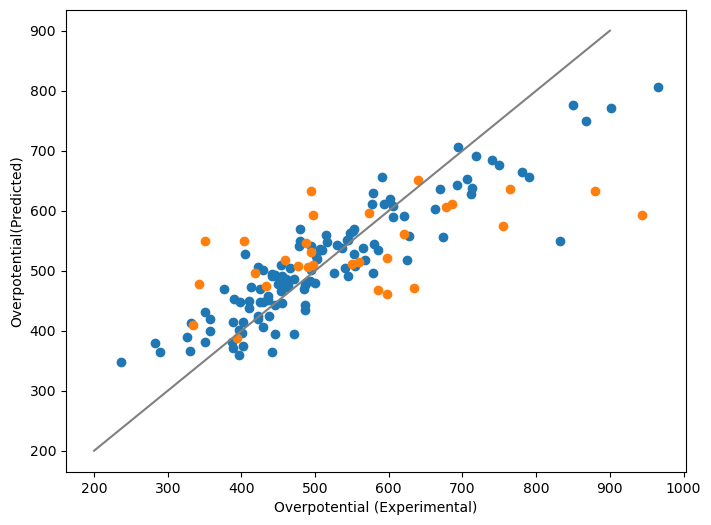

In [62]:
plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.plot([200, 900], [200,900], 'gray')
ax.scatter(y_train, gp.predict(X_train))
ax.scatter(y_test, gp.predict(X_test))
ax.set_xlabel('Overpotential (Experimental)')
ax.set_ylabel('Overpotential(Predicted)')

plt.show()

In [63]:
train_RMSE = np.sqrt(sum((gp.predict(X_train)-gp.predict(X_train).mean())**2)/len(X_train))
train_r2 = sum((gp.predict(X_train)-y_train.mean())**2)/sum((y_train-y_train.mean())**2)
train_RMSE, train_r2

(96.28206468603807, 0.5241929458510949)

In [64]:
test_RMSE = np.sqrt(sum((gp.predict(X_test)-gp.predict(X_test).mean())**2)/len(X_test))
test_r2 = sum((gp.predict(X_test)-y_test.mean())**2)/sum((y_test-y_test.mean())**2)
test_RMSE, test_r2

(66.00651448323885, 0.21515494344877123)

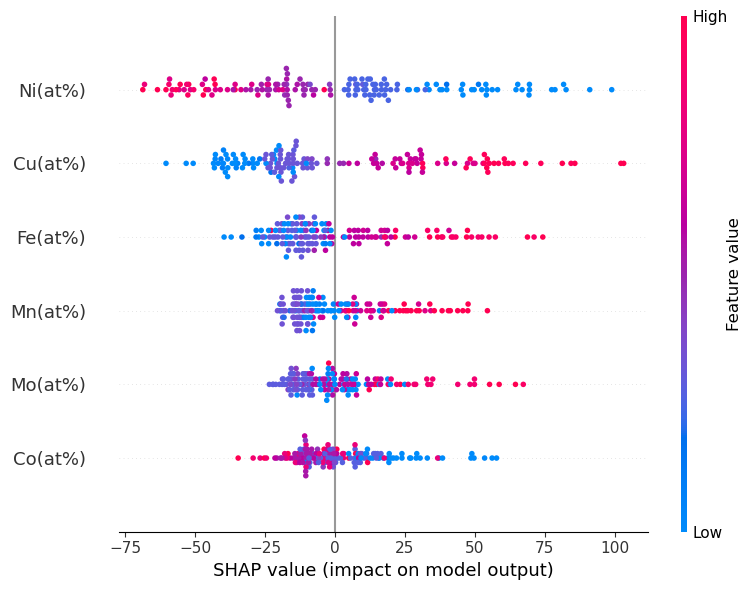

In [65]:
#SHAP model explanation
explainer = shap.Explainer(gp.predict,X)
shap_values = explainer(X)                                 ## bar plot
shap.summary_plot(shap_values, X, plot_size = [8,6], feature_names = ['Mn(at%)', 'Fe(at%)', 'Co(at%)', 'Ni(at%)', 'Cu(at%)', 'Mo(at%)'])           ## summary    